In [29]:
import pandas as pd
import re
import numpy as np
import os
import multiprocessing as mp
import logging
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns', 700)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all columns
pd.set_option('display.float_format', '{:.5f}'.format)

In [30]:
df = pd.read_csv("Data/DF_Combined_2025_1h_Processed.csv")
df.head()

,coin,date,RET,close,high,low,open,volume
0,AAVEUSDT,2024-12-31 23:00:00,-0.00287,308.70000,311.66000,307.85000,309.59000,16569.70000
1,AAVEUSDT,2025-01-01 00:00:00,0.01591,313.61000,313.72000,308.72000,308.73000,27473.90000
2,AAVEUSDT,2025-01-01 01:00:00,-0.00077,313.37000,314.28000,311.37000,313.61000,23172.20000
3,AAVEUSDT,2025-01-01 02:00:00,0.00377,314.55000,316.92000,313.21000,313.37000,26176.50000
4,AAVEUSDT,2025-01-01 03:00:00,-0.00741,312.22000,314.58000,311.81000,314.53000,13005.10000


In [31]:
def add_rsi_features(df: pd.DataFrame, windows=(7, 14, 28, 50, 75, 100)) -> pd.DataFrame:
    """
    Add RSI_{window} columns per coin. Robust to duplicate indices.
    Requires columns: ['coin','date','close'].
    """
    def calc_rsi(close: pd.Series, window: int) -> pd.Series:
        delta = close.diff()
        gain = delta.clip(lower=0.0)
        loss = (-delta).clip(lower=0.0)

        avg_gain = gain.rolling(window, min_periods=window).mean()
        avg_loss = loss.rolling(window, min_periods=window).mean()

        rs = avg_gain / (avg_loss + 1e-12)
        rsi = 100 - (100 / (1 + rs))
        return rsi

    out = df.copy()

    # ensure proper ordering within each coin
    if not np.issubdtype(out['date'].dtype, np.datetime64):
        out['date'] = pd.to_datetime(out['date'], errors='coerce')
    out.sort_values(['coin', 'date'], inplace=True)

    # compute per coin and assign by index (avoids reindexing errors)
    for w in windows:
        col = f'RSI_{w}'
        out[col] = np.nan  # pre-create column
        for coin, g in out.groupby('coin'):
            out.loc[g.index, col] = calc_rsi(g['close'], w).values

    return out


df = add_rsi_features(df, windows=(7, 14, 28, 24*2, 24*3, 24*5, 24*7, 24*14, 24*30))
df = df.dropna()
df.head()


,coin,date,RET,close,high,low,open,volume,RSI_7,RSI_14,RSI_28,RSI_48,RSI_72,RSI_120,RSI_168,RSI_336,RSI_720
720,AAVEUSDT,2025-01-30 23:00:00,-0.00574,315.36000,319.48000,315.13000,317.18000,15502.90000,45.11512,61.30086,66.82228,65.17831,53.43246,48.11259,47.28295,50.19439,50.15723
721,AAVEUSDT,2025-01-31 00:00:00,0.00999,318.51000,318.63000,313.26000,315.36000,25200.60000,51.16279,63.58301,67.66552,66.19758,55.76252,48.40233,48.47991,50.25958,50.11578
722,AAVEUSDT,2025-01-31 01:00:00,0.00546,320.25000,320.41000,316.68000,318.50000,20953.70000,59.77137,63.47070,67.62997,65.50172,56.84044,48.90770,48.65250,49.89999,50.16245
723,AAVEUSDT,2025-01-31 02:00:00,-0.00987,317.09000,320.75000,315.63000,320.25000,18808.80000,41.61594,62.23200,68.63245,64.00636,55.13464,48.42787,48.47556,49.88299,50.05992
724,AAVEUSDT,2025-01-31 03:00:00,-0.00369,315.92000,317.60000,314.00000,317.07000,22673.20000,55.01097,52.22685,70.60174,61.78172,54.31518,47.60089,47.62576,49.91208,50.08733


In [32]:
# Define the look-ahead periods (in hours)
HORIZONS = [1, 2, 5, 10, 24, 24*3, 24*5, 24*7, 24*14, 24*30]

# 1. Create the future return columns
for h in HORIZONS:
    # Column name will be 'Future_RET_H' where H is the horizon
    col_name = f'Future_RET_{h}H'
    
    
    # --- Correct approach for cumulative future return (Gross Return Product) ---
    def calculate_future_cumulative_return(group, hours):
        # Calculate the cumulative gross return (1 + R_t) * (1 + R_t+1) ... (1 + R_t+h-1)
        gross_return = (1 + group['RET']).rolling(window=hours).apply(lambda x: x.prod(), raw=True)
        # Shift back by 'hours' and subtract 1 to get the simple cumulative return from t to t+h
        future_return = gross_return.shift(-hours) - 1
        return future_return

    df[col_name] = df.groupby('coin').apply(
        lambda x: calculate_future_cumulative_return(x, h), 
        include_groups=False
    ).reset_index(level=0, drop=True)
    

# Drop rows where the target return cannot be calculated (at the end of the time series)
df = df.dropna(subset=[f'Future_RET_{h}H' for h in HORIZONS])
df.head()

,coin,date,RET,close,high,low,open,volume,RSI_7,RSI_14,RSI_28,RSI_48,RSI_72,RSI_120,RSI_168,RSI_336,RSI_720,Future_RET_1H,Future_RET_2H,Future_RET_5H,Future_RET_10H,Future_RET_24H,Future_RET_72H,Future_RET_120H,Future_RET_168H,Future_RET_336H,Future_RET_720H
720,AAVEUSDT,2025-01-30 23:00:00,-0.00574,315.36000,319.48000,315.13000,317.18000,15502.90000,45.11512,61.30086,66.82228,65.17831,53.43246,48.11259,47.28295,50.19439,50.15723,0.00999,0.01551,-0.00907,0.00821,0.05467,-0.18119,-0.13753,-0.23478,-0.18747,-0.38185
721,AAVEUSDT,2025-01-31 00:00:00,0.00999,318.51000,318.63000,313.26000,315.36000,25200.60000,51.16279,63.58301,67.66552,66.19758,55.76252,48.40233,48.47991,50.25958,50.11578,0.00546,-0.00446,-0.00097,-0.00681,0.04000,-0.21889,-0.15943,-0.24351,-0.20134,-0.38956
722,AAVEUSDT,2025-01-31 01:00:00,0.00546,320.25000,320.41000,316.68000,318.50000,20953.70000,59.77137,63.47070,67.62997,65.50172,56.84044,48.90770,48.65250,49.89999,50.16245,-0.00987,-0.01352,0.00550,0.01686,0.02948,-0.32053,-0.16465,-0.23663,-0.20322,-0.39500
723,AAVEUSDT,2025-01-31 02:00:00,-0.00987,317.09000,320.75000,315.63000,320.25000,18808.80000,41.61594,62.23200,68.63245,64.00636,55.13464,48.42787,48.47556,49.88299,50.05992,-0.00369,-0.01448,0.00779,0.03589,0.04084,-0.31496,-0.15122,-0.22221,-0.19118,-0.38888
724,AAVEUSDT,2025-01-31 03:00:00,-0.00369,315.92000,317.60000,314.00000,317.07000,22673.20000,55.01097,52.22685,70.60174,61.78172,54.31518,47.60089,47.62576,49.91208,50.08733,-0.01083,0.00722,0.00165,0.03349,0.03191,-0.27314,-0.15824,-0.22123,-0.17688,-0.38532


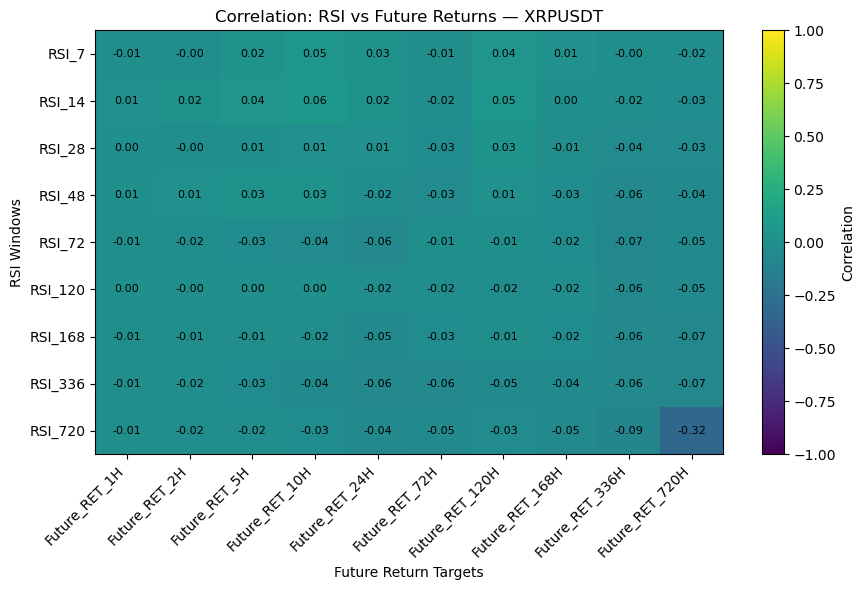

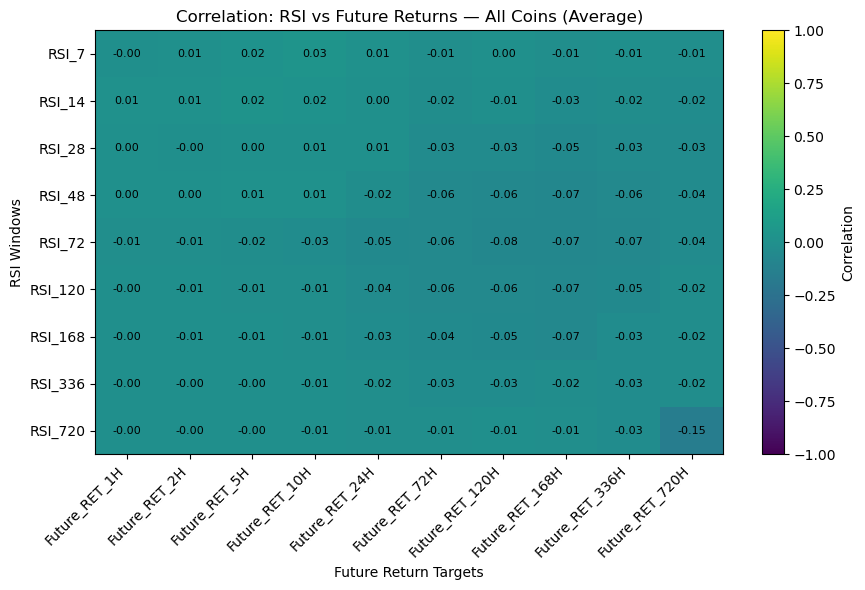

In [33]:
def _natural_sort_by_number(cols, prefix):
    """Sort columns like 'RSI_7','RSI_14' or 'Future_RET_10H' by the number."""
    def key(c):
        if not c.startswith(prefix):
            return (10**9, c)
        m = re.search(r'(\d+)', c)
        return (int(m.group(1)) if m else 10**9, c)
    return sorted([c for c in cols if c.startswith(prefix)], key=key)

def plot_rsi_corr(
    df: pd.DataFrame,
    coin: str = "all",
    rsi_prefix: str = "RSI_",
    target_prefix: str = "Future_RET_",
    figsize=(9, 6),
    annotate: bool = True,
    cmap: str = None  # keep None to use Matplotlib default per your plotting rules
):
    """
    Plot correlation between RSI features and future returns, per coin or averaged across coins.

    Parameters
    ----------
    df : pd.DataFrame
        Must include 'coin' and RSI/target columns.
    coin : str, default 'all'
        Specific coin symbol or 'all' to average across coins.
    rsi_prefix : str, default 'RSI_'
        Prefix for RSI feature columns.
    target_prefix : str, default 'Future_RET_'
        Prefix for future return target columns.
    figsize : tuple
        Matplotlib figure size.
    annotate : bool
        Write correlation numbers on the heatmap.
    cmap : str or None
        Matplotlib colormap name. Leave None to use default.

    Returns
    -------
    pd.DataFrame
        Correlation matrix (rows=RSI windows, cols=future-return horizons).
    """
    if "coin" not in df.columns:
        raise ValueError("DataFrame must contain a 'coin' column.")

    # Identify and sort columns
    rsi_cols    = _natural_sort_by_number(df.columns, rsi_prefix)
    target_cols = _natural_sort_by_number(df.columns, target_prefix)
    if not rsi_cols:
        raise ValueError(f"No RSI columns found starting with '{rsi_prefix}'.")
    if not target_cols:
        raise ValueError(f"No target columns found starting with '{target_prefix}'.")

    # Choose coins
    coins = [coin] if coin != "all" else df["coin"].dropna().unique().tolist()
    if not coins:
        raise ValueError("No coins found.")

    # Collect per-coin correlation blocks (RSI x Targets)
    blocks = []
    for c in coins:
        sub = df[df["coin"] == c]
        if sub.empty:
            continue
        corr = sub.loc[:, rsi_cols + target_cols].corr()
        # Make sure missing columns don't break selection
        kk = corr.reindex(index=rsi_cols, columns=target_cols)
        blocks.append(kk)

    if not blocks:
        raise ValueError(f"No data for coin(s): {coins}")

    # Average across coins if requested
    if coin == "all":
        # Align all blocks to the same shape, then take mean
        aligned = [b.reindex(index=rsi_cols, columns=target_cols) for b in blocks]
        key_corr = pd.concat(aligned, keys=range(len(aligned))) \
                     .groupby(level=1).mean() \
                     .reindex(index=rsi_cols, columns=target_cols)
        title = "All Coins (Average)"
    else:
        key_corr = blocks[0]
        title = coin

    # Plot
    vals = key_corr.to_numpy()
    vals_disp = np.nan_to_num(vals, nan=0.0)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(vals_disp, aspect="auto", vmin=-1, vmax=1, cmap=cmap)

    ax.set_yticks(range(len(rsi_cols)))
    ax.set_yticklabels(rsi_cols)
    ax.set_xticks(range(len(target_cols)))
    ax.set_xticklabels(target_cols, rotation=45, ha="right")

    ax.set_title(f"Correlation: RSI vs Future Returns — {title}")
    ax.set_xlabel("Future Return Targets")
    ax.set_ylabel("RSI Windows")

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Correlation")

    if annotate:
        for i in range(vals.shape[0]):
            for j in range(vals.shape[1]):
                v = key_corr.iat[i, j]
                ax.text(j, i, ("nan" if pd.isna(v) else f"{v:.2f}"),
                        ha="center", va="center", fontsize=8)

    fig.tight_layout()
    plt.show()

    return key_corr


# Single coin
_ = plot_rsi_corr(df, coin="XRPUSDT")

# Average across all coins
_ = plot_rsi_corr(df, coin="all")


### RSI Indicator Results Summary

RSI shows **weak but consistent negative correlations** with future returns, especially at **longer horizons**.  
Short-term effects (1–10h) are mostly random, while multi-day horizons (24h–720h) reveal a **gradual mean-reversion pattern**, reaching about −0.15 for the longest periods.  
This suggests that **overbought and oversold conditions** have limited predictive power intraday but may indicate **slow reversals** over several days.
